# Recipe Generation Data Preprocessing

This notebook provides a unified preprocessing pipeline for recipe generation datasets
across multiple language models. It handles dataset loading, tokenization, and
label masking for training causal language models on recipe generation tasks.


In [ ]:
# Install required packages
! pip install -q evaluate torch tqdm datasets peft transformers rouge_score hf_transfer colorama
! pip install -q -U bitsandbytes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.1 MB/s eta 0:00:00


In [ ]:
# Standard library imports
from typing import Dict, List, Optional, Tuple, Any
from pprint import pprint

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer

## Section 1: Model Configuration Registry

Centralized configuration for all supported models. This registry stores model-specific
settings including paths, system message support, and message formatting preferences.


In [ ]:
MODEL_CONFIGS = {
    "llama": {
        "path": "meta-llama/Llama-3.2-1B-Instruct",
        "supports_system": True,
        "system_message": "You will generate one cooking recipe. List all necessary ingredients and give detailed steps.",
        "user_message_template": "Include ingredients: {ner}",
        "include_title_in_user": False,
    },
    "mistral": {
        "path": "mistralai/Mistral-7B-Instruct-v0.3",
        "supports_system": False,
        "system_message": "You will generate one cooking recipe. List all necessary ingredients and give detailed steps.",
        "user_message_template": "Include ingredients: {ner}",
        "include_title_in_user": False,

    },
    "gemma": {
        "path": "google/gemma-2-9b-it",
        "supports_system": False,
        "system_message": "You will generate one cooking recipe. List all necessary ingredients and give detailed steps.",
        "user_message_template": "Include ingredients: {ner}",
        "include_title_in_user": False,
    },
    "qwen": {
        "path": "Qwen/Qwen2.5-7B-Instruct",
        "supports_system": True,
        "system_message": "You will generate one cooking recipe. List all necessary ingredients and give detailed steps.",
        "user_message_template": "Include ingredients: {ner}",
        "include_title_in_user": False,
    },
    "olmo": {
        "path": "allenai/OLMoE-1B-7B-0924-Instruct",
        "supports_system": False,
        "system_message": "You will generate one cooking recipe. List all necessary ingredients and give detailed steps.",
        "user_message_template": "Include ingredients: {ner}",
        "include_title_in_user": False,
    },
}

def get_model_config(model_name: str) -> Dict[str, Any]:
    """
    Retrieve configuration for a specific model.

    Args:
        model_name: Model identifier (llama, mistral, gemma, qwen, olmo)

    Returns:
        Dictionary containing model configuration

    Raises:
        ValueError: If model_name is not found in registry
    """
    if model_name.lower() not in MODEL_CONFIGS:
        available = ", ".join(MODEL_CONFIGS.keys())
        raise ValueError(f"Unknown model: {model_name}. Available models: {available}")
    return MODEL_CONFIGS[model_name.lower()].copy()


## Section 2: Dataset Loading and Validation

Functions for loading, validating, and splitting the recipe dataset.


In [ ]:
def setup_dataset_splits(
    dataset_name: str = "skadewdl3/recipe-nlg-llama2",
    val_size: float = 0.05,
    seed: int = 42,
    filter_invalid: bool = True
) -> Dict[str, Dataset]:
    """
    Set up train/validation/test splits with optional filtering.

    Args:
        dataset_name: HuggingFace dataset name
        val_size: Fraction of training data to use for validation (0.05 = 5%)
        seed: Random seed for reproducibility
        filter_invalid: Whether to remove samples with missing fields

    Returns:
        Dictionary with keys 'train', 'validation', and optionally 'test'
    """
    print(f"[INFO] Loading dataset: {dataset_name}")
    dataset = load_dataset(dataset_name)

    print("\n[INFO] Original Dataset:")
    for split_name in dataset.keys():
        print(f"  {split_name}: {len(dataset[split_name]):,} samples")

    if filter_invalid:
        print("\n[INFO] Filtering Invalid Samples:")

        def is_valid(sample):
            """Check if sample has all required fields."""
            return (
                sample.get('title') is not None and str(sample.get('title', '')).strip() and
                sample.get('ingredients') is not None and str(sample.get('ingredients', '')).strip() and
                sample.get('directions') is not None and str(sample.get('directions', '')).strip() and
                sample.get('prompt') is not None and str(sample.get('prompt', '')).strip() and
                '[INST]' in str(sample.get('prompt', '')) and '[/INST]' in str(sample.get('prompt', ''))
            )

        for split_name in dataset.keys():
            original_size = len(dataset[split_name])
            dataset[split_name] = dataset[split_name].filter(is_valid)
            new_size = len(dataset[split_name])
            removed = original_size - new_size
            print(f"  {split_name}: kept {new_size:,} / {original_size:,} (removed {removed:,})")

    print(f"\n[INFO] Creating Validation Split ({val_size*100:.1f}% of train)")
    train_val_split = dataset['train'].train_test_split(test_size=val_size, seed=seed)

    dataset_splits = {
        'train': train_val_split['train'],
        'validation': train_val_split['test'],
    }

    if 'test' in dataset:
        dataset_splits['test'] = dataset['test']
    else:
        print("[WARNING] No test split found. Consider creating one from validation.")

    print("\n[INFO] Final Dataset Splits:")
    for split_name, split_data in dataset_splits.items():
        print(f"  {split_name}: {len(split_data):,} samples")

    total = sum(len(split_data) for split_data in dataset_splits.values())
    print("\n[INFO] Split Percentages:")
    for split_name, split_data in dataset_splits.items():
        percentage = (len(split_data) / total) * 100
        print(f"  {split_name}: {percentage:.2f}%")

    return dataset_splits


def inspect_dataset_sample(dataset: Dataset, index: int = 0) -> Dict[str, Any]:
    """
    Inspect a single sample from the dataset.

    Args:
        dataset: Dataset to inspect
        index: Index of sample to inspect

    Returns:
        Dictionary containing the sample data
    """
    sample = dataset[index]
    print(f"[INFO] Dataset Sample (index {index}):")
    print(f"  Keys: {list(sample.keys())}")
    for key, value in sample.items():
        if isinstance(value, str) and len(value) > 100:
            print(f"  {key}: {value[:100]}...")
        else:
            print(f"  {key}: {value}")
    return sample


In [ ]:
# Load and split dataset
dataset_splits = setup_dataset_splits(
    dataset_name="skadewdl3/recipe-nlg-llama2",
    val_size=0.05,
    seed=42,
    filter_invalid=True
)

train_data = dataset_splits['train']
val_data = dataset_splits['validation']
test_data = dataset_splits.get('test', None)

# Inspect sample
print("\n" + "="*80)
sample = inspect_dataset_sample(train_data, index=0)


[INFO] Loading dataset: skadewdl3/recipe-nlg-llama2


README.md:   0%|          | 0.00/822 [00:00<?, ?B/s]

data/train-00000-of-00007-73f49c89fca0ad(…):   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00001-of-00007-1d10e9ac88b427(…):   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00002-of-00007-959831b6c5f145(…):   0%|          | 0.00/218M [00:00<?, ?B/s]

data/train-00003-of-00007-d6f01c4aafdff2(…):   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00004-of-00007-7f66de25de3e0e(…):   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00005-of-00007-2725711559578e(…):   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00006-of-00007-27897e3bd5e7ae(…):   0%|          | 0.00/217M [00:00<?, ?B/s]

data/test-00000-of-00001-f0fb9d9a114d945(…):   0%|          | 0.00/169M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2008027 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/223115 [00:00<?, ? examples/s]


[INFO] Original Dataset:
  train: 2,008,027 samples
  test: 223,115 samples

[INFO] Filtering Invalid Samples:


Filter:   0%|          | 0/2008027 [00:00<?, ? examples/s]

  train: kept 2,008,026 / 2,008,027 (removed 1)


Filter:   0%|          | 0/223115 [00:00<?, ? examples/s]

  test: kept 223,115 / 223,115 (removed 0)

[INFO] Creating Validation Split (5.0% of train)

[INFO] Final Dataset Splits:
  train: 1,907,624 samples
  validation: 100,402 samples
  test: 223,115 samples

[INFO] Split Percentages:
  train: 85.50%
  validation: 4.50%
  test: 10.00%

[INFO] Dataset Sample (index 0):
  Keys: ['id', 'title', 'ingredients', 'directions', 'link', 'source', 'NER', 'prompt']
  id: 1042505
  title: Sherby'S Cornmeal Fried Okra
  ingredients: - fresh okra
- cornmeal
- salt
  directions: - Mix your cornmeal and salt well in a gallon sized Ziploc bag
- Add okra, about 1 1/2 cups at a tim...
  link: www.food.com/recipe/sherbys-cornmeal-fried-okra-166012
  source: Gathered
  NER: fresh okra, cornmeal, salt
  prompt: <s>[INST] <<SYS>>
You will generate one cooking recipe. List all necessary ingredients and give deta...


## Section 3: Core Preprocessing Functions

Unified functions for building recipe messages and preprocessing samples for any model.
These functions use the model configuration registry to handle model-specific differences.


In [ ]:
def build_recipe_messages(
    sample: Dict[str, Any],
    model_name: str,
    include_assistant: bool = True
) -> List[Dict[str, str]]:
    """
    Build chat messages in the format required by the specified model.

    This function handles model-specific differences:
    - Models with system message support (llama, qwen) use separate system/user/assistant
    - Models without system support (mistral, gemma, olmo) merge system into user message

    Args:
        sample: Dictionary with 'title', 'ingredients', 'directions', 'NER' fields
        model_name: Model identifier (llama, mistral, gemma, qwen, olmo)
        include_assistant: If True, include the expected recipe output

    Returns:
        List of message dictionaries with 'role' and 'content' keys
    """
    config = get_model_config(model_name)
    messages = []

    # Build user message content
    user_lines = []

    if config['supports_system']:
        # Models with system message support: separate system and user
        system_msg = {
            "role": "system",
            "content": config['system_message']
        }
        messages.append(system_msg)

        # User message with ingredients
        user_content = config['user_message_template'].format(ner=sample.get('NER', ''))
        user_msg = {"role": "user", "content": user_content}
        messages.append(user_msg)
    else:
        # Models without system support: merge system into user message
        user_lines.append(config['system_message'])
        user_lines.append("")

        if config.get('include_title_in_user') and sample.get('title'):
            title_prefix = config.get('title_prefix', 'Title:')
            user_lines.append(f"{title_prefix} {sample['title']}")

        ner = sample.get('NER', '')
        user_content = config['user_message_template'].format(ner=ner)
        user_lines.append(user_content)

        user_msg = {
            "role": "user",
            "content": "\n\n".join(user_lines)
        }
        messages.append(user_msg)

    # Add assistant response if requested
    if include_assistant:
        assistant_response = (
            f"Certainly! Here's a delicious recipe for:\n"
            f"[ {sample.get('title', 'Recipe')} ]\n\n"
            f"[ INGREDIENTS ]\n{sample.get('ingredients', '')}\n\n"
            f"[ DIRECTIONS ]\n{sample.get('directions', '')}"
        )
        messages.append({"role": "assistant", "content": assistant_response})

    return messages


In [ ]:
def preprocess_recipe_samples(
    examples: Dict[str, List],
    tokenizer: AutoTokenizer,
    model_name: str,
    max_length: int = 512
) -> Dict[str, List[List[int]]]:
    """
    Tokenize recipe samples and apply assistant-only masking for causal LM training.

    This function:
    1. Builds chat messages for each sample
    2. Applies the model's chat template
    3. Tokenizes the text
    4. Creates labels with -100 for prompt tokens (masked) and actual token IDs for assistant response

    Args:
        examples: Batch dictionary with 'title', 'ingredients', 'directions', 'NER' fields
        tokenizer: Tokenizer with chat template support
        model_name: Model identifier for message formatting
        max_length: Maximum sequence length

    Returns:
        Dictionary with 'input_ids', 'labels', 'attention_mask' keys
    """
    input_ids_list = []
    labels_list = []
    attn_masks = []

    # Process each sample in the batch
    for title, ingredients, directions, ner in zip(
        examples["title"],
        examples["ingredients"],
        examples["directions"],
        examples["NER"]
    ):
        sample = {
            "title": title,
            "ingredients": ingredients,
            "directions": directions,
            "NER": ner
        }

        # Build messages with and without assistant response
        msgs_full = build_recipe_messages(sample, model_name, include_assistant=True)
        msgs_prompt = build_recipe_messages(sample, model_name, include_assistant=False)

        # Apply chat template
        text_full = tokenizer.apply_chat_template(
            msgs_full,
            tokenize=False,
            add_generation_prompt=False
        )
        text_prompt = tokenizer.apply_chat_template(
            msgs_prompt,
            tokenize=False,
            add_generation_prompt=True
        )

        # Get prompt length in characters for finding assistant start position
        prompt_len = len(text_prompt)

        # Tokenize with offset mapping to find where assistant response starts
        tokens = tokenizer(
            text_full,
            max_length=max_length,
            truncation=True,
            padding=False,
            add_special_tokens=False,
            return_offsets_mapping=True,
        )

        # Find where assistant response starts using character offset mapping
        start_idx = len(tokens["input_ids"])
        for i, (start_char, _) in enumerate(tokens["offset_mapping"]):
            if start_char >= prompt_len:
                start_idx = i
                break

        # Create labels: mask prompt tokens (-100), keep assistant tokens (actual IDs)
        labels = [-100] * start_idx + tokens["input_ids"][start_idx:]

        # Ensure labels match input_ids length
        if len(labels) > len(tokens["input_ids"]):
            labels = labels[:len(tokens["input_ids"])]

        input_ids_list.append(tokens["input_ids"])
        labels_list.append(labels)
        attn_masks.append(tokens["attention_mask"])

    return {
        "input_ids": input_ids_list,
        "labels": labels_list,
        "attention_mask": attn_masks,
    }


## Section 4: Tokenizer Utilities

Functions for loading and configuring tokenizers, and comparing vocabulary sizes.


In [ ]:
# Tokenizer cache to avoid reloading
_tokenizer_cache = {}

def load_tokenizer(model_name: str, use_cache: bool = True) -> AutoTokenizer:
    """
    Load and configure tokenizer for a specific model.

    Args:
        model_name: Model identifier (llama, mistral, gemma, qwen, olmo)
        use_cache: If True, reuse previously loaded tokenizers

    Returns:
        Configured AutoTokenizer instance
    """
    if use_cache and model_name in _tokenizer_cache:
        return _tokenizer_cache[model_name]

    config = get_model_config(model_name)
    tokenizer = AutoTokenizer.from_pretrained(config['path'])

    # Configure padding
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    if use_cache:
        _tokenizer_cache[model_name] = tokenizer

    print(f"[INFO] Loaded tokenizer for {model_name}: {config['path']}")
    print(f"  Vocab size: {len(tokenizer):,}")
    print(f"  Pad token: {tokenizer.pad_token}")

    return tokenizer


def compare_tokenizer_vocabularies(model_names: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Compare vocabulary sizes across multiple models.

    Args:
        model_names: List of model identifiers. If None, compares all models.

    Returns:
        DataFrame with model names and vocabulary sizes
    """
    if model_names is None:
        model_names = list(MODEL_CONFIGS.keys())

    vocab_data = []
    for model_name in model_names:
        try:
            tokenizer = load_tokenizer(model_name, use_cache=True)
            vocab_size = len(tokenizer)
            vocab_data.append({
                'model': model_name,
                'vocab_size': vocab_size,
                'model_path': MODEL_CONFIGS[model_name]['path']
            })
        except Exception as e:
            print(f"[WARNING] Failed to load {model_name}: {e}")
            vocab_data.append({
                'model': model_name,
                'vocab_size': 0,
                'model_path': MODEL_CONFIGS[model_name]['path']
            })

    df = pd.DataFrame(vocab_data)
    df = df.sort_values('vocab_size', ascending=False)

    print("\n[INFO] Tokenizer Vocabulary Comparison:")
    print(df.to_string(index=False))

    if len(df) > 1:
        print(f"\n[INFO] Largest vocabulary: {df.iloc[0]['model']} ({df.iloc[0]['vocab_size']:,} tokens)")
        print(f"[INFO] Smallest vocabulary: {df.iloc[-1]['model']} ({df.iloc[-1]['vocab_size']:,} tokens)")
        print(f"[INFO] Average vocabulary size: {df['vocab_size'].mean():,.0f} tokens")

    return df


In [ ]:
# Compare all tokenizers
vocab_comparison = compare_tokenizer_vocabularies()


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

[INFO] Loaded tokenizer for llama: meta-llama/Llama-3.2-1B-Instruct
  Vocab size: 128,256
  Pad token: <|eot_id|>


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

[INFO] Loaded tokenizer for mistral: mistralai/Mistral-7B-Instruct-v0.3
  Vocab size: 32,768
  Pad token: </s>


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

[INFO] Loaded tokenizer for gemma: google/gemma-2-9b-it
  Vocab size: 256,000
  Pad token: <pad>


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

[INFO] Loaded tokenizer for qwen: Qwen/Qwen2.5-7B-Instruct
  Vocab size: 151,665
  Pad token: <|endoftext|>


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

[INFO] Loaded tokenizer for olmo: allenai/OLMoE-1B-7B-0924-Instruct
  Vocab size: 50,281
  Pad token: <pad>

[INFO] Tokenizer Vocabulary Comparison:
  model  vocab_size                         model_path
  gemma      256000               google/gemma-2-9b-it
   qwen      151665           Qwen/Qwen2.5-7B-Instruct
  llama      128256   meta-llama/Llama-3.2-1B-Instruct
   olmo       50281  allenai/OLMoE-1B-7B-0924-Instruct
mistral       32768 mistralai/Mistral-7B-Instruct-v0.3

[INFO] Largest vocabulary: gemma (256,000 tokens)
[INFO] Smallest vocabulary: mistral (32,768 tokens)
[INFO] Average vocabulary size: 123,794 tokens


## Section 5: Visualization and Analysis

Unified visualization functions for inspecting tokenization and label masking.


In [ ]:
def visualize_tokenization(
    processed_samples: Dict[str, List],
    tokenizer: AutoTokenizer,
    model_name: str,
    sample_index: int = 0,
    show_detailed: bool = True,
    max_rows: int = 50
) -> pd.DataFrame:
    """
    Visualize tokenization and label masking for a processed sample.

    Args:
        processed_samples: Output from preprocess_recipe_samples
        tokenizer: Tokenizer used for processing
        model_name: Model identifier for display
        sample_index: Index of sample to visualize
        show_detailed: If True, show token-by-token breakdown
        max_rows: Maximum rows to display in detailed view

    Returns:
        DataFrame with tokenization details
    """
    print("="*80)
    print(f"TOKENIZATION AND MASKING VISUALIZATION - {model_name.upper()}")
    print("="*80 + "\n")

    # Extract sample
    ex = {k: v[sample_index] for k, v in processed_samples.items()}

    # Decode tokens
    tokens = [tokenizer.decode([tid], skip_special_tokens=False) for tid in ex["input_ids"]]

    # Create DataFrame
    df = pd.DataFrame({
        "index": range(len(ex["input_ids"])),
        "token": tokens,
        "input_id": ex["input_ids"],
        "attention_mask": ex["attention_mask"],
        "label": ex["labels"],
    })

    # Add masking information
    df["masked"] = df["label"].apply(lambda x: x == -100)
    df["training"] = df["masked"].apply(lambda x: "[MASKED]" if x else "[TRAINING]")

    # Summary statistics
    total_tokens = len(df)
    masked_tokens = df['masked'].sum()
    training_tokens = (~df['masked']).sum()

    print("[INFO] Summary Statistics:")
    print(f"  Total tokens: {total_tokens}")
    print(f"  Masked tokens (not trained): {masked_tokens} ({masked_tokens/total_tokens*100:.1f}%)")
    print(f"  Training tokens: {training_tokens} ({training_tokens/total_tokens*100:.1f}%)")
    print()

    if show_detailed:
        print("[INFO] Token-by-Token Breakdown (first {} rows):".format(min(max_rows, len(df))))
        print("-"*80)
        pd.set_option("display.max_rows", max_rows)
        pd.set_option("display.max_colwidth", 50)
        print(df[["index", "token", "input_id", "label", "training"]].head(max_rows).to_string(index=False))
        print()

    # Show masked vs training portions
    print("="*80)
    print("[MASKED] PORTION (NOT TRAINED ON)")
    print("="*80)
    masked_tokens_list = df[df['masked']]['input_id'].tolist()
    masked_text = tokenizer.decode(masked_tokens_list, skip_special_tokens=False)
    print(masked_text[:500] + "..." if len(masked_text) > 500 else masked_text)
    print()

    print("="*80)
    print("[TRAINING] PORTION (MODEL LEARNS THIS)")
    print("="*80)
    training_tokens_list = df[~df['masked']]['input_id'].tolist()
    training_text = tokenizer.decode(training_tokens_list, skip_special_tokens=False)
    print(training_text[:500] + "..." if len(training_text) > 500 else training_text)
    print()

    return df


def get_tokenization_statistics(
    processed_samples: Dict[str, List],
    model_name: str
) -> Dict[str, Any]:
    """
    Calculate statistics for processed samples.

    Args:
        processed_samples: Output from preprocess_recipe_samples
        model_name: Model identifier

    Returns:
        Dictionary with statistics
    """
    all_lengths = [len(ids) for ids in processed_samples['input_ids']]
    all_masked_counts = [
        sum(1 for label in labels if label == -100)
        for labels in processed_samples['labels']
    ]
    all_training_counts = [
        sum(1 for label in labels if label != -100)
        for labels in processed_samples['labels']
    ]

    stats = {
        'model': model_name,
        'num_samples': len(processed_samples['input_ids']),
        'avg_length': np.mean(all_lengths),
        'min_length': np.min(all_lengths),
        'max_length': np.max(all_lengths),
        'avg_masked_tokens': np.mean(all_masked_counts),
        'avg_training_tokens': np.mean(all_training_counts),
        'avg_masked_ratio': np.mean(all_masked_counts) / np.mean(all_lengths),
    }

    return stats


## Section 6: Example Usage

Demonstrations of preprocessing for each supported model.


In [ ]:
def demonstrate_model_preprocessing(
    model_name: str,
    dataset: Dataset,
    sample_index: int = 0,
    max_length: int = 512,
    show_visualization: bool = True
) -> Dict[str, Any]:
    """
    Complete preprocessing demonstration for a specific model.

    Args:
        model_name: Model identifier
        dataset: Dataset to process
        sample_index: Index of sample to use
        max_length: Maximum sequence length
        show_visualization: If True, show detailed visualization

    Returns:
        Dictionary with processed samples and statistics
    """
    print(f"\n{'='*80}")
    print(f"DEMONSTRATION: {model_name.upper()}")
    print(f"{'='*80}\n")

    # Load tokenizer
    tokenizer = load_tokenizer(model_name)

    # Get sample
    sample = {
        "title": dataset[sample_index]['title'],
        "ingredients": dataset[sample_index]['ingredients'],
        "directions": dataset[sample_index]['directions'],
        "NER": dataset[sample_index]['NER']
    }

    print("[INFO] Input Sample:")
    print(f"  Title: {sample['title']}")
    print(f"  NER: {sample['NER'][:80]}...")
    print(f"  Ingredients: {sample['ingredients'][:80]}...")
    print()

    # Build messages
    messages = build_recipe_messages(sample, model_name, include_assistant=True)
    print("[INFO] Built Messages:")
    for msg in messages:
        content_preview = msg['content'][:100] + "..." if len(msg['content']) > 100 else msg['content']
        print(f"  {msg['role']}: {content_preview}")
    print()

    # Apply chat template
    chat_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False
    )
    print("[INFO] Chat Template Output (first 200 chars):")
    print(f"  {chat_text[:200]}...")
    print()

    # Create dataset with single sample
    recipe_dataset = Dataset.from_dict({
        "title": [sample["title"]],
        "ingredients": [sample["ingredients"]],
        "directions": [sample["directions"]],
        "NER": [sample["NER"]],
    })

    # Preprocess
    processed_samples = preprocess_recipe_samples(
        recipe_dataset,
        tokenizer,
        model_name,
        max_length=max_length
    )

    # Get statistics
    stats = get_tokenization_statistics(processed_samples, model_name)
    print("[INFO] Processing Statistics:")
    for key, value in stats.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.2f}")
        else:
            print(f"  {key}: {value}")
    print()

    # Visualize if requested
    if show_visualization:
        df = visualize_tokenization(
            processed_samples,
            tokenizer,
            model_name,
            sample_index=0,
            show_detailed=True,
            max_rows=1000
        )
        return {
            'processed_samples': processed_samples,
            'statistics': stats,
            'dataframe': df
        }

    return {
        'processed_samples': processed_samples,
        'statistics': stats
    }


In [ ]:
# Example: Process sample with Llama model
llama_result = demonstrate_model_preprocessing(
    model_name="llama",
    dataset=train_data,
    sample_index=0,
    max_length=512,
    show_visualization=True
)



DEMONSTRATION: LLAMA

[INFO] Input Sample:
  Title: Sherby'S Cornmeal Fried Okra
  NER: fresh okra, cornmeal, salt...
  Ingredients: - fresh okra
- cornmeal
- salt...

[INFO] Built Messages:
  system: You will generate one cooking recipe. List all necessary ingredients and give detailed steps.
  user: Include ingredients: fresh okra, cornmeal, salt
  assistant: Certainly! Here's a delicious recipe for:
[ Sherby'S Cornmeal Fried Okra ]

[ INGREDIENTS ]
- fresh ...

[INFO] Chat Template Output (first 200 chars):
  <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 22 Nov 2025

You will generate one cooking recipe. List all necessary ingredients and giv...

[INFO] Processing Statistics:
  model: llama
  num_samples: 1
  avg_length: 209.00
  min_length: 209
  max_length: 209
  avg_masked_tokens: 62.00
  avg_training_tokens: 147.00
  avg_masked_ratio: 0.30

TOKENIZATION AND MASKING VISUALIZATION - LLAMA

[INFO] Summary Statistics:

### Additional Model Examples

You can process samples with any supported model using the same unified interface:


In [ ]:
# Example: Process with Mistral (no system message support)
mistral_result = demonstrate_model_preprocessing(
     model_name="mistral",
     dataset=train_data,
     sample_index=0,
     max_length=512,
     show_visualization=True
 )




DEMONSTRATION: MISTRAL

[INFO] Input Sample:
  Title: Sherby'S Cornmeal Fried Okra
  NER: fresh okra, cornmeal, salt...
  Ingredients: - fresh okra
- cornmeal
- salt...

[INFO] Built Messages:
  user: You will generate one cooking recipe. List all necessary ingredients and give detailed steps.



Inc...
  assistant: Certainly! Here's a delicious recipe for:
[ Sherby'S Cornmeal Fried Okra ]

[ INGREDIENTS ]
- fresh ...

[INFO] Chat Template Output (first 200 chars):
  <s>[INST] You will generate one cooking recipe. List all necessary ingredients and give detailed steps.



Include ingredients: fresh okra, cornmeal, salt[/INST] Certainly! Here's a delicious recipe f...

[INFO] Processing Statistics:
  model: mistral
  num_samples: 1
  avg_length: 208.00
  min_length: 208
  max_length: 208
  avg_masked_tokens: 35.00
  avg_training_tokens: 173.00
  avg_masked_ratio: 0.17

TOKENIZATION AND MASKING VISUALIZATION - MISTRAL

[INFO] Summary Statistics:
  Total tokens: 208
  Masked tokens (not 

In [ ]:
# Example: Process with Gemma (different system message)
gemma_result = demonstrate_model_preprocessing(
     model_name="gemma",
     dataset=train_data,
     sample_index=0,
     max_length=512,
     show_visualization=True
  )


DEMONSTRATION: GEMMA

[INFO] Input Sample:
  Title: Sherby'S Cornmeal Fried Okra
  NER: fresh okra, cornmeal, salt...
  Ingredients: - fresh okra
- cornmeal
- salt...

[INFO] Built Messages:
  user: You will generate one cooking recipe. List all necessary ingredients and give detailed steps.



Inc...
  assistant: Certainly! Here's a delicious recipe for:
[ Sherby'S Cornmeal Fried Okra ]

[ INGREDIENTS ]
- fresh ...

[INFO] Chat Template Output (first 200 chars):
  <bos><start_of_turn>user
You will generate one cooking recipe. List all necessary ingredients and give detailed steps.



Include ingredients: fresh okra, cornmeal, salt<end_of_turn>
<start_of_turn>mo...

[INFO] Processing Statistics:
  model: gemma
  num_samples: 1
  avg_length: 180.00
  min_length: 180
  max_length: 180
  avg_masked_tokens: 36.00
  avg_training_tokens: 144.00
  avg_masked_ratio: 0.20

TOKENIZATION AND MASKING VISUALIZATION - GEMMA

[INFO] Summary Statistics:
  Total tokens: 180
  Masked tokens (not traine

In [ ]:
# Example: Process with Qwen (system message support)
qwen_result = demonstrate_model_preprocessing(
     model_name="qwen",
     dataset=train_data,
     sample_index=0,
     max_length=512,
     show_visualization=True
  )


DEMONSTRATION: QWEN

[INFO] Input Sample:
  Title: Sherby'S Cornmeal Fried Okra
  NER: fresh okra, cornmeal, salt...
  Ingredients: - fresh okra
- cornmeal
- salt...

[INFO] Built Messages:
  system: You will generate one cooking recipe. List all necessary ingredients and give detailed steps.
  user: Include ingredients: fresh okra, cornmeal, salt
  assistant: Certainly! Here's a delicious recipe for:
[ Sherby'S Cornmeal Fried Okra ]

[ INGREDIENTS ]
- fresh ...

[INFO] Chat Template Output (first 200 chars):
  <|im_start|>system
You will generate one cooking recipe. List all necessary ingredients and give detailed steps.<|im_end|>
<|im_start|>user
Include ingredients: fresh okra, cornmeal, salt<|im_end|>
<|...

[INFO] Processing Statistics:
  model: qwen
  num_samples: 1
  avg_length: 188.00
  min_length: 188
  max_length: 188
  avg_masked_tokens: 40.00
  avg_training_tokens: 148.00
  avg_masked_ratio: 0.21

TOKENIZATION AND MASKING VISUALIZATION - QWEN

[INFO] Summary Statistics:
  

In [ ]:

# Example: Process with OLMo
olmo_result = demonstrate_model_preprocessing(
     model_name="olmo",
     dataset=train_data,
     sample_index=0,
     max_length=512,
     show_visualization=True
 )


DEMONSTRATION: OLMO

[INFO] Input Sample:
  Title: Sherby'S Cornmeal Fried Okra
  NER: fresh okra, cornmeal, salt...
  Ingredients: - fresh okra
- cornmeal
- salt...

[INFO] Built Messages:
  user: You will generate one cooking recipe. List all necessary ingredients and give detailed steps.



Inc...
  assistant: Certainly! Here's a delicious recipe for:
[ Sherby'S Cornmeal Fried Okra ]

[ INGREDIENTS ]
- fresh ...

[INFO] Chat Template Output (first 200 chars):
  <|endoftext|><|user|>
You will generate one cooking recipe. List all necessary ingredients and give detailed steps.



Include ingredients: fresh okra, cornmeal, salt
<|assistant|>
Certainly! Here's a...

[INFO] Processing Statistics:
  model: olmo
  num_samples: 1
  avg_length: 197.00
  min_length: 197
  max_length: 197
  avg_masked_tokens: 42.00
  avg_training_tokens: 155.00
  avg_masked_ratio: 0.21

TOKENIZATION AND MASKING VISUALIZATION - OLMO

[INFO] Summary Statistics:
  Total tokens: 197
  Masked tokens (not trained):

COMPARING TOKENIZER VOCABULARY SIZES

Loading Llama-3.2-1B tokenizer...
   Llama-3.2-1B: 128,256 tokens
Loading Mistral-7B tokenizer...
   Mistral-7B: 32,768 tokens
Loading Gemma-2-9B tokenizer...
   Gemma-2-9B: 256,000 tokens
Loading Qwen-2.5-7B tokenizer...
   Qwen-2.5-7B: 151,665 tokens
Loading OLMoE-1B-7B tokenizer...
   OLMoE-1B-7B: 50,281 tokens



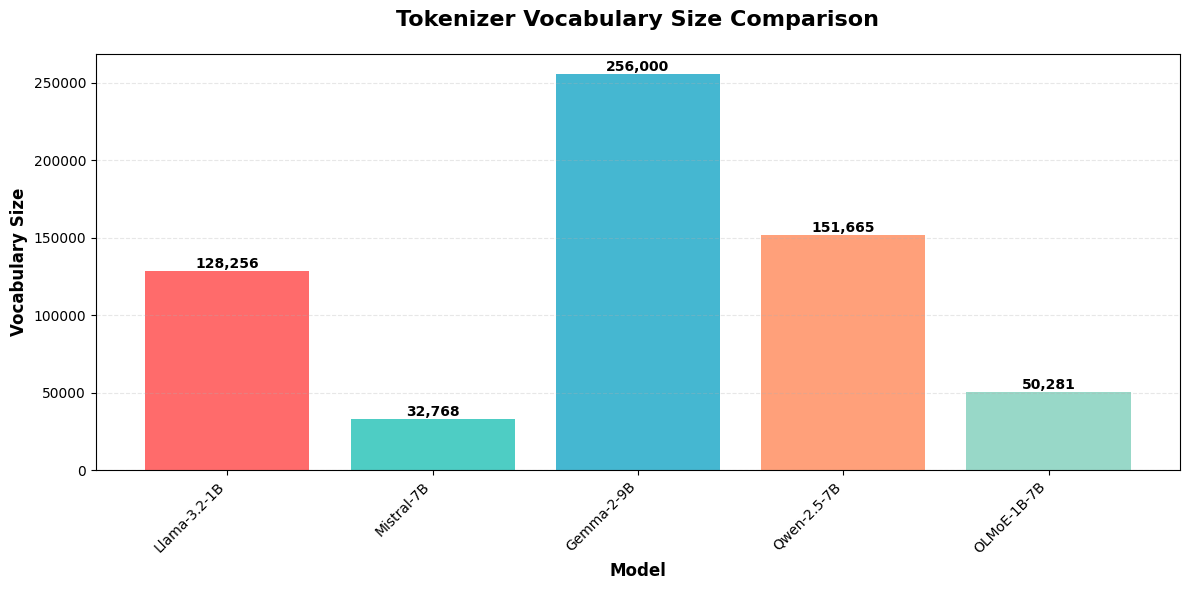


SUMMARY STATISTICS
Total models compared: 5
Largest vocabulary: Gemma-2-9B (256,000 tokens)
Smallest vocabulary: Mistral-7B (32,768 tokens)
Average vocabulary size: 123,794 tokens
Vocabulary size range: 223,232 tokens

DETAILED COMPARISON TABLE
Model                     Vocabulary Size         Percentage of Max
--------------------------------------------------------------------------------
Llama-3.2-1B                      128,256                     50.1%
Mistral-7B                         32,768                     12.8%
Gemma-2-9B                        256,000                    100.0%
Qwen-2.5-7B                       151,665                     59.2%
OLMoE-1B-7B                        50,281                     19.6%



In [ ]:
# ============================================================================
# Compare Vocabulary Sizes of All Models
# ============================================================================

print("="*80)
print("COMPARING TOKENIZER VOCABULARY SIZES")
print("="*80 + "\n")

# Load all tokenizers and get their vocabulary sizes
models_info = [
    {
        "name": "Llama-3.2-1B",
        "model_path": "meta-llama/Llama-3.2-1B-Instruct",
        "variable_name": "tokenizer_llama"
    },
    {
        "name": "Mistral-7B",
        "model_path": "mistralai/Mistral-7B-Instruct-v0.3",
        "variable_name": "tokenizer_mistral"
    },
    {
        "name": "Gemma-2-9B",
        "model_path": "google/gemma-2-9b-it",
        "variable_name": "tokenizer_gemma"
    },
    {
        "name": "Qwen-2.5-7B",
        "model_path": "Qwen/Qwen2.5-7B-Instruct",
        "variable_name": "tokenizer_qwen"
    },
    {
        "name": "OLMoE-1B-7B",
        "model_path": "allenai/OLMoE-1B-7B-0924-Instruct",
        "variable_name": "tokenizer_olmo"
    }
]

# Load tokenizers and collect vocabulary sizes
vocab_sizes = []
model_names = []

for model_info in models_info:
    try:
        print(f"Loading {model_info['name']} tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_info["model_path"])

        vocab_size = len(tokenizer)
        vocab_sizes.append(vocab_size)
        model_names.append(model_info["name"])

        print(f"   {model_info['name']}: {vocab_size:,} tokens")

    except Exception as e:
        print(f"   Error loading {model_info['name']}: {e}")
        # Try to get vocab size from already loaded tokenizer
        try:
            if model_info["variable_name"] == "tokenizer_llama" and 'tokenizer' in globals():
                vocab_size = len(globals()['tokenizer'])
                vocab_sizes.append(vocab_size)
                model_names.append(model_info["name"])
                print(f"   Using existing {model_info['name']} tokenizer: {vocab_size:,} tokens")
            elif model_info["variable_name"] in globals():
                vocab_size = len(globals()[model_info["variable_name"]])
                vocab_sizes.append(vocab_size)
                model_names.append(model_info["name"])
                print(f"   Using existing {model_info['name']} tokenizer: {vocab_size:,} tokens")
            else:
                vocab_sizes.append(0)
                model_names.append(model_info["name"])
        except:
            vocab_sizes.append(0)
            model_names.append(model_info["name"])

print()

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, vocab_sizes, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'])

# Customize the chart
plt.title('Tokenizer Vocabulary Size Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Vocabulary Size', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, (bar, size) in enumerate(zip(bars, vocab_sizes)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Show the chart
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total models compared: {len(model_names)}")
print(f"Largest vocabulary: {model_names[vocab_sizes.index(max(vocab_sizes))]} ({max(vocab_sizes):,} tokens)")
print(f"Smallest vocabulary: {model_names[vocab_sizes.index(min(vocab_sizes))]} ({min(vocab_sizes):,} tokens)")
print(f"Average vocabulary size: {sum(vocab_sizes)/len(vocab_sizes):,.0f} tokens")
print(f"Vocabulary size range: {max(vocab_sizes) - min(vocab_sizes):,} tokens")
print()

# Create a detailed comparison table
print("="*80)
print("DETAILED COMPARISON TABLE")
print("="*80)
print(f"{'Model':<20} {'Vocabulary Size':>20} {'Percentage of Max':>25}")
print("-"*80)
max_vocab = max(vocab_sizes)
for name, size in zip(model_names, vocab_sizes):
    percentage = (size / max_vocab) * 100
    print(f"{name:<20} {size:>20,} {percentage:>24.1f}%")
print()



## Summary

This notebook provides a unified preprocessing pipeline for recipe generation that:

1. **Centralized Configuration**: All model-specific settings in one registry
2. **Unified Functions**: Single set of functions works for all models
3. **Efficient Processing**: Tokenizer caching and batch operations
4. **Clear Visualization**: Unified visualization for any model
5. **Better Documentation**: Comprehensive docstrings and type hints

### Key Functions:

- `get_model_config(model_name)`: Retrieve model configuration
- `setup_dataset_splits(...)`: Load and split dataset
- `build_recipe_messages(sample, model_name)`: Build chat messages
- `preprocess_recipe_samples(examples, tokenizer, model_name)`: Tokenize and mask
- `load_tokenizer(model_name)`: Load and cache tokenizers
- `visualize_tokenization(...)`: Visualize tokenization results
- `demonstrate_model_preprocessing(...)`: Complete preprocessing demo

### Supported Models:

- **llama**: meta-llama/Llama-3.2-1B-Instruct (system message support)
- **mistral**: mistralai/Mistral-7B-Instruct-v0.3 (no system message)
- **gemma**: google/gemma-2-9b-it (no system message, different prompt)
- **qwen**: Qwen/Qwen2.5-7B-Instruct (system message support)
- **olmo**: allenai/OLMoE-1B-7B-0924-Instruct (no system message)
